In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from IPython.display import display

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

### Import Data

In [2]:
df_raw = pd.read_csv('data/titanic_train.csv')
train_cats(df_raw)
X, y, nas = proc_df(df_raw, 'Survived')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
x_sub = X_train[['Sex', 'Pclass']]

## Root of the Tree

In [4]:
class RandomForest():
    def __init__ (self, x, y, n_trees, sample_sz=None, min_leaf=5):
        np.random.seed(42) 
        if sample_sz is None:
            sample_sz=len(y)
        self.x, self.y, self.sample_sz, self.min_leaf = x, y, sample_sz, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
    
    def create_tree(self):
        idxs = np.random.choice(len(self.y), replace=True, size = self.sample_sz)      
        return DecisionTree(self.x.iloc[idxs], 
                            self.y[idxs],
                            idxs=np.array(range(self.sample_sz)),
                            min_leaf=self.min_leaf)
    
    def predict(self, x):
        percents = np.mean([t.predict(x) for t in self.trees], axis=0)
        return [1 if p>0.5 else 0 for p in percents]

In [5]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):  
        if idxs is None: 
            idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf = x, y, idxs, min_leaf   
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.check_features()
        
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_cols(self): return self.x.values[self.idxs, self.var_idx]
    
    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}'
        if not self.is_leaf:
            s+= f'; gini:{self.score}; split:{self.split}; var: {self.split_name}'
        return s
            
    def check_features(self):
        for i in range(self.c): 
            self.find_best_split(i)
    
    def find_best_split(self, var_idx): pass

In [6]:
tree = RandomForest(x=x_sub, y=y_train, n_trees=1).trees[0]
x_samp, y_samp = tree.x, tree.y

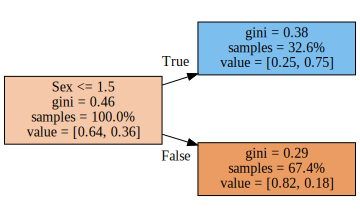

In [7]:
m = RandomForestClassifier(n_estimators=1, max_depth=1, bootstrap=False)
m.fit(x_samp, y_samp)

dot_data = export_graphviz(m.estimators_[0], feature_names=x_samp.columns, filled=True,
                           proportion=True, rotate=True, precision=2)
IPython.display.display(graphviz.Source(re.sub('Tree {', f'Tree {{ size=6; ratio=0.6', dot_data)))

### First split

In [8]:
def find_gini(left, right, y):
    classes  = np.unique(y)
    n = len(left) + len(right)
    s1=0; s2=0
    
    for k in classes:   
        p1 = len(np.nonzero(y[left] == k)[0]) / len(left)
        s1 += p1*p1 
        p2 = len(np.nonzero(y[right] == k)[0]) / len(right)
        s2 += p2*p2 
    
    gini = (1-s1)*(len(left)/n) + (1-s2)*(len(right)/n)
    
    return gini

In [9]:
def find_best_split(self, var_idx):
    
    x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]   
    sort_idx = np.argsort(x)
    sort_y = y[sort_idx]
    sort_x = x[sort_idx]
    
    for i in range(0, self.n-self.min_leaf-1):
        if i < self.min_leaf or sort_x[i] == sort_x[i+1]: continue 
        lhs = np.nonzero(sort_x <= sort_x[i])[0]
        rhs = np.nonzero(sort_x > sort_x[i])[0]
        if rhs.sum()==0: continue
        
        gini = find_gini(lhs, rhs, sort_y)

        if gini<self.score: 
            self.var_idx, self.score, self.split = var_idx, gini, sort_x[i]

In [10]:
DecisionTree.find_best_split = find_best_split

In [11]:
tree = RandomForest(x_sub, y_train, 1).trees[0]; tree

n: 712; gini:0.3182463192561023; split:1; var: Sex

### Further Splits 

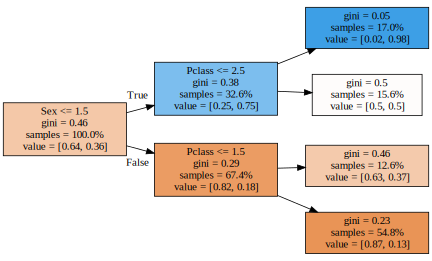

In [12]:
m = RandomForestClassifier(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_samp, y_samp)

dot_data = export_graphviz(m.estimators_[0], feature_names=x_samp.columns, filled=True,
                           proportion=True, rotate=True, precision=2)
IPython.display.display(graphviz.Source(re.sub('Tree {', f'Tree {{ size=6; ratio=0.6', dot_data)))

In [13]:
def check_features(self):
    
    for i in range(self.c): 
        self.find_best_split(i)
    if self.is_leaf: return 
    
    #otherwise this split becomes the root of a "new tree" 
    x = self.split_cols
    lhs = np.nonzero(x <= self.split)[0]
    rhs = np.nonzero(x > self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs]) 
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs]) 

In [14]:
DecisionTree.check_features = check_features

In [15]:
tree = RandomForest(x_sub, y_train, 1).trees[0]
tree

n: 712; gini:0.3182463192561023; split:1; var: Sex

In [16]:
tree.lhs

n: 232; gini:0.26442558260740084; split:2; var: Pclass

In [17]:
tree.rhs

n: 480; gini:0.2717948717948718; split:1; var: Pclass

### Predictions

In [18]:
def predict(self, x):
    return np.array([self.predict_row(xi) for xi in x])

DecisionTree.predict = predict

def predict_row(self, xi):
    if self.is_leaf: return self.val 
    best = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    return best.predict_row(xi)

DecisionTree.predict_row = predict_row

In [19]:
cols = ['Pclass', 'Age', 'Sex', 'Fare_Groups','Deck']

In [20]:
m = RandomForestClassifier(n_estimators=10, min_samples_leaf=3, bootstrap=True)
m.fit(X_train[cols], y_train)
pred_scikit = m.predict(X_test[cols].values)

In [21]:
metrics.accuracy_score(y_test, pred_scikit)

0.8212290502793296

In [22]:
ens = RandomForest(X_train[cols], y_train, n_trees=10, min_leaf=3)
pred_RF = ens.predict(X_test[cols].values)

In [23]:
metrics.accuracy_score(y_test, pred_RF)

0.8100558659217877

### Appendix
#### Notes on Gini: 

x = np.array([1, 1, 1, 1, 1, 2, 2, 2]) #5 female & 4 male
y = np.array([1, 1, 1, 1, 0, 0, 0, 0]) #4 survived & 4 died 

p(female) = $ \frac{5}{8} $  
p(male) = $ \frac{3}{8} $  

p(Survived|female) = $ \frac{4}{5} $  
p(Died|female) = $ \frac{1}{5} $  
Gini = 1 - [$ (\frac{4}{5})^{2} + (\frac{1}{5})^{2} $] = 0.32  

p(Survived|male) = $ \frac{0}{3} $  
p(Died|male) = $ \frac{3}{3} $  
Gini = 1 - [$ (\frac{0}{3})^{2} + (\frac{3}{3})^{2} $] = 0

weighted sum:   
Gini for this split = $ (\frac{5}{8})*(0.32) + (\frac{3}{8})*(0) $ = 0.2